# Two-qubit gate between two fluxonia: Ficheux scheme

In this notebook we study the two-qubit gate between two fluxonia fluxonium described in Ficheux et al. Phys. Rev. X 11, 021026 (2021)

In [2]:
import numpy as np
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.hsbasis import weyl_by_index
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import util_ficheux_2021 as util

from IPython.display import display, Latex

The gate is based on the following driven Hamiltonian of two-capacitively coupled fluxonium qubits

$$\hat{H} = \hat{H}^{(0)}_A + \hat{H}^{(0)}_B + \hat{V} + \hat{H}_{drive}$$

$$\hat{H}^{(0)}_A = 4 E_{C,A} \cdot \hat{n}^2_A + \frac{1}{2}E_{L,A}\cdot\hat{\varphi}^2_A - E_{J,A}\cos\left(\hat{\varphi}_A - \phi_{ext,A}\right)$$

$$\hat{H}^{(0)}_B = 4 E_{C,B} \cdot \hat{n}^2_B + \frac{1}{2}E_{L,B}\cdot\hat{\varphi}^2_B - E_{J,B}\cos\left(\hat{\varphi}_B - \phi_{ext,B}\right)$$

$$\hat{V} = J_C \cdot \hat{n}_A \cdot \hat{n}_B$$

$$\frac{\hat{H}_{drive}}{h} = \left( \epsilon_A \hat{n}_A + \epsilon_B \hat{n}_B \right) \cos(2\pi f_d t)$$

# Introducing the qubits and the coupled system

In [3]:
temperature = 0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4
levels_f = 5

#Fluxonium A
flx_a = pysqkit.qubits.Fluxonium(
    label='F_A', 
    charge_energy=.973, 
    induct_energy=.457, 
    joseph_energy=5.899, 
    diel_loss_tan=7.1*1e-6*0.0, #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy
)
flx_a.diagonalize_basis(levels_f)

#Fluxonium B
flx_b = pysqkit.qubits.Fluxonium(
    label='F_B', 
    charge_energy=1.027, 
    induct_energy=.684, 
    joseph_energy=5.768, 
    diel_loss_tan=7.1*1e-6*0.0, #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy
)
flx_b.diagonalize_basis(levels_f)

# We also add a drive on the fluxonia (both are driven since there is a single drive line)
flx_a.add_drive(
    pysqkit.drives.microwave_drive,
    label='cz_drive_a',
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)
flx_b.add_drive(
    pysqkit.drives.microwave_drive,
    label='cz_drive_b',
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_f**2 - d_comp

jc = 0.224
coupled_sys = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

The basis principle behind the gate is illustrated in the following figure

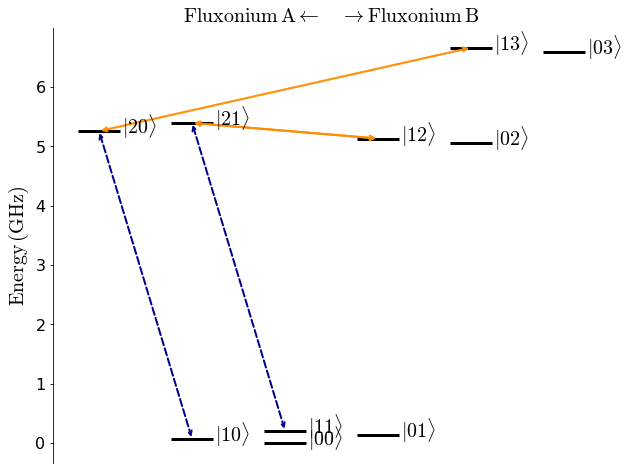

In [4]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13']

util.energy_levels_diagram(bare_system, level_list)

The figure shows the energy of the bare levels. The orange arrows indicate the non-zero matrix elements between the (bare) levels provided by the capacitive coupling $V$: the more shaded the arrow the weaker the coupling. The idea is to design the system so that the $| 2 1 \rangle$-$|12 \rangle$ transition is close to resonance so that the levels get sufficiently hybridized. A CZ gate can then be realized by driving the $|1 \rangle$-$|2 \rangle$ transition of the first fluxonium, which induces transitions depicted by the blue, dashed arrow in the figure. 

We look at the following quantities : 

$$\zeta_{ZZ} = E_{00} + E_{11} - E_{01} - E_{10}$$
$$\Delta = \left( E_{21} - E_{11} \right) -  \left( E_{20} - E_{10} \right)$$

The $\Delta$ is similar at the one in Ficheux but looking at the 0-3 transition of the Fluxonium.

For the given parameters we have

In [5]:
display(Latex(r'$\xi_{{ZZ}}/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.zz(coupled_sys))))
display(Latex(r'$\Delta/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.delta(coupled_sys))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Matching the parameters
For this case we look at the 10-13 and 00-03 transitions so we process the corresponding Rabi frequencies :

$$\Omega_{11-21}  = \left| \epsilon_A \langle 11 | \hat{n}_A | 21 \rangle + \epsilon_B \langle 11 | \hat{n}_B | 21 \rangle \right|$$
$$\Omega_{10-20}  = \left| \epsilon_A \langle 10 | \hat{n}_A | 20 \rangle + \epsilon_B \langle 10 | \hat{n}_B | 20 \rangle \right|$$

And then :
$$r = \dfrac{\Omega_{11-21}}{\Omega_{10-20}} \text{  and  } \dfrac{\delta}{\Delta} = \dfrac{r^2 - \sqrt{(r^2-1)^2 + r^2 }} {r^2 - 1}$$ 

With these conventions taken in the paper :
$$\Delta = f_{11-21} - f_{10-20}$$
$$\delta = f_{11-21} - f_d$$

These conventions are taken in orde to have : $\Omega = \sqrt{\Omega_{11-21}^2  + \delta^2} = \sqrt{\Omega_{10-20}^2  + (\delta - \Delta)^2}$

The $\Delta$ is fixed by the parameters of the qubits, we now need to settle the values for the drive parameters.

First we need to fix the $\varepsilon$.

We take the condition of the paper :
$$\Omega = \Delta$$

However, one equation for two parameters is not enough. We assume, as in the paper, that the fluxonium A is driven much more than the fluxonium B. In particular, we assume a proportionality constant between the drives. Now we have enough constraints to find values for every parameters.


With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$.

In order to setup the optimization define the following function that respects the scipy.optimize.minimize syntax. The vector of variable x0 in this case has length 2: the first entry is a reference drive strength, while the second the drive frequency. The drive parameters for each qubit are defined by providing the ratio between the qubit drive strength and the reference drive strength. This can be used to take into account potential classical crosstalk.

In [ ]:
x0 = np.array([0.032, 5.2]) #initial guess
eps_ratios = {'F_A': 1.0, 'F_B':1.0/0.9}
args_to_pass = (['10', '20'], ['11', '21'], coupled_sys, eps_ratios) 

start = time.time()

minimization_result = minimize(util.func_to_minimize, x0, args=args_to_pass)

end = time.time()

display(Latex(r'$\mathrm{{Minimization \, time}} = {:.3f} \, s$'.format(end - start)))

In [ ]:
display(Latex(r'$y_{{\mathrm{{min}}}} = {:.2e}$'.format(minimization_result['fun'])))
display(Latex(r'$\epsilon_{{\mathrm{{d, opt}}}} = {:.7f}$'.format(minimization_result['x'][0])))
display(Latex(r'$f_{{\mathrm{{d,opt}}}} = {:.5f} \, \mathrm{{GHz}}$'.format(minimization_result['x'][1])))

In [ ]:
eps_drive = minimization_result['x'][0]
freq_drive = minimization_result['x'][1]
rabi_period = 1/util.delta(coupled_sys)
t_rise = 18.0 # [ns]
t_tot = 60    # [ns]
pts_per_drive_period = 5 

nb_points = int(t_tot*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_tot, nb_points)

coupled_sys['F_A'].drives['cz_drive_a'].set_params(phase=0, time=tlist, rise_time=t_rise, 
                                                 amp=eps_drive*eps_ratios['F_A'], freq=freq_drive)
coupled_sys['F_B'].drives['cz_drive_b'].set_params(phase=0, time=tlist, rise_time=t_rise, 
                                                 amp=eps_drive*eps_ratios['F_B'], freq=freq_drive)

We introduce the TomoEnv object. We also refine the absolute and relative tolerance of the qutip solver 

In [ ]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-12
simu_opt.rtol = 1e-10
env_syst = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, options=simu_opt)

In what follows we are interested in obtaining a superoperator representation of a quantum operation in the computational subspace that we here define

In [ ]:
state_labels = ['00', '01', '10', '11']
comp_states = []
for label in state_labels:
    comp_states.append(coupled_sys.state(label)[1])

We can easily obtain the superoperator in the Weyl basis. Notice that this gives information only within the defined computational subspace and not on the leakage subspace. Thus the following superoperator is complete knowledge of the states within the computational subspaces only if the leakage is zero. However, the following superoperator is the one needed to compute process fidelities as described in Eq. 8 of Wood-Gambetta Phys. Rev. A 97, 032306 (2018). The method to_super in the TomoEnv class is parallelized and we can specify the number of processes. 

In [ ]:
n_process = 4

start = time.time()
sup_op = env_syst.to_super(comp_states, weyl_by_index, n_process)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

We now use the previous superoperator to compute the process fidelity and average gate fidelity with respect to a $\mathrm{CZ}$ gate. First of all, we need to obtain the single-qubit gate corrections. This can be done directly from the superoperator via the following function.

In [ ]:
sq_corr = util.single_qubit_corrections(sup_op, weyl_by_index)
sq_corr_sup = trf.kraus_to_super(sq_corr, weyl_by_index)
total_sup_op = sq_corr_sup.dot(sup_op)

We now compute the process fidelity. In order to do this we first need to obtain the superoperator representation of the $\mathrm{CZ}$ in the Weyl basis. This can be done via the function qutip.util.transformations.kraus_to_super

In [ ]:
cz = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])
cz_super = trf.kraus_to_super(cz, weyl_by_index)

We can now compute the process fidelity

In [ ]:
f_pro = average_process_fidelity(cz_super, total_sup_op)
display(Latex(r'$F_{{pro}} = {:.5f}$'.format(f_pro)))

The average leakage and seepage can be computed within the TomoEnv class. This is because we just need to specify a subspace to determine them, similarly to the determination of the superoperator. We use Eq. 2 and 3 in Wood-Gambetta Phys. Rev. A 97, 032306 (2018) to calculate the average leakage and seepage respectively.

In [ ]:
avg_leakage = env_syst.leakage(comp_states)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage)))

In [ ]:
avg_seepage = env_syst.seepage(comp_states)
display(Latex(r'$L_2(\mathcal{{E}} ) = {:.7f}$'.format(avg_seepage)))

We can also check that with the selected accuracy of the qutip solver, for unitary dynamics (set loss tangents equal to zero) we reproduce the relation between leakage and seepage $d_1 L_1(\mathcal{E}) = d_2 L_2(\mathcal{E})$ ($d_1=4, d_2 = 21$)

In [ ]:
display(Latex(r'$d_1 L_1(\mathcal{{E}} ) = {:.7f}$'.format(d_comp*avg_leakage)))

In [ ]:
display(Latex(r'$d_2 L_2(\mathcal{{E}} ) = {:.7f}$'.format(d_leak*avg_seepage)))

Finally, the average gate fidelity is

In [ ]:
f_gate = average_gate_fidelity(cz_super, total_sup_op, avg_leakage)
display(Latex(r'$F_{{gate}} = {:.5f}$'.format(f_gate)))